# Problem Set 2 Notebook 

### Contributors : 
* Zeineb Sahnoun
* Firas Kanoun
* Sami Ben Hassen
* Nourchene Ben Romdhane

# Relevant Imports

In [41]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Network Creation

**Read the data and create a network graph**

In [42]:
edges = []
vertices = set()
with open("SMS-network.txt", "r") as f:
    lines = f.readlines()
    for l in lines:
        relation = [int(x) for x in l.split()]
        edges.append(tuple(relation))
        vertices.update(relation)
vertices = list(vertices)

In [43]:
graph = nx.Graph()
graph.add_nodes_from(vertices)
graph.add_edges_from(edges)

**This is how our network looks like**

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


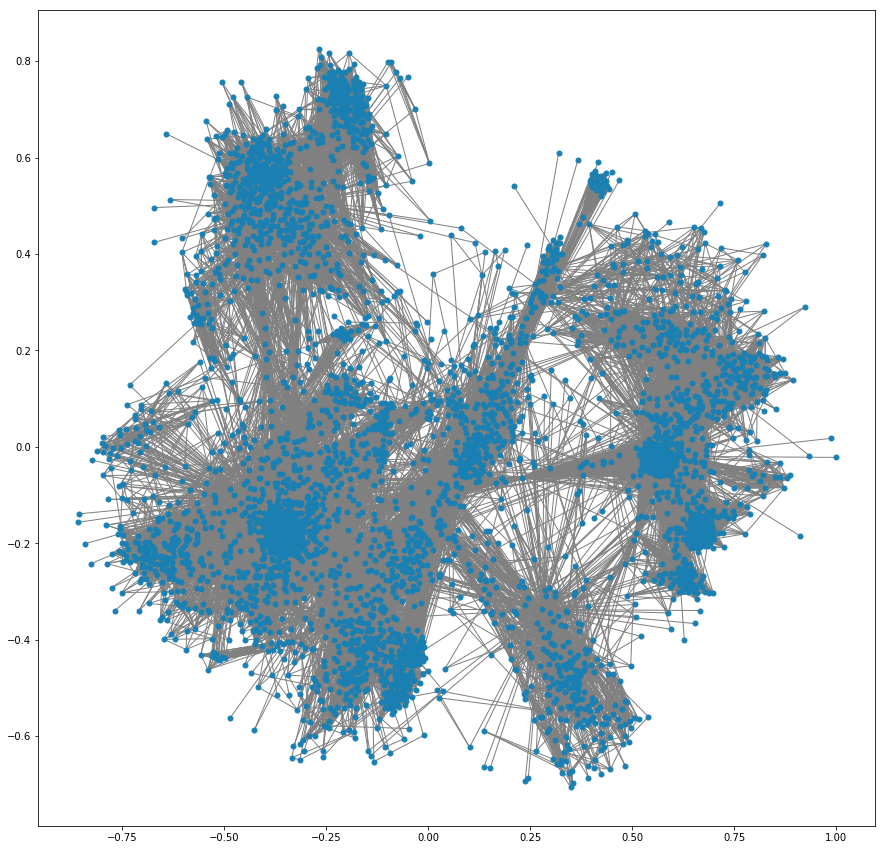

In [44]:
plt.figure(figsize=(15, 15))

pos = nx.spring_layout(graph, k=0.1)
nx.draw_networkx(
    graph,
    pos,
    node_size=25,
    node_color=(0.1, 0.5, 0.7, 0.6),
    with_labels=False,
    edge_color='gray')

**Now we try to identify the influencers: It should be the nodes with highest degree in our graph.**

## The influencers in general

### Top 20

In [45]:
degrees = np.array(graph.degree())
degrees = sorted(degrees, key=lambda x: x[1], reverse=True)
influencers_sorted = [x[0] for x in degrees]
top20_influencers = influencers_sorted[:20]
top20_influencers

[107,
 1684,
 1912,
 3437,
 0,
 2543,
 2347,
 1888,
 1800,
 1663,
 1352,
 2266,
 483,
 348,
 1730,
 1985,
 1941,
 2233,
 2142,
 1431]

### Visualize top 20 influencers on the graph :

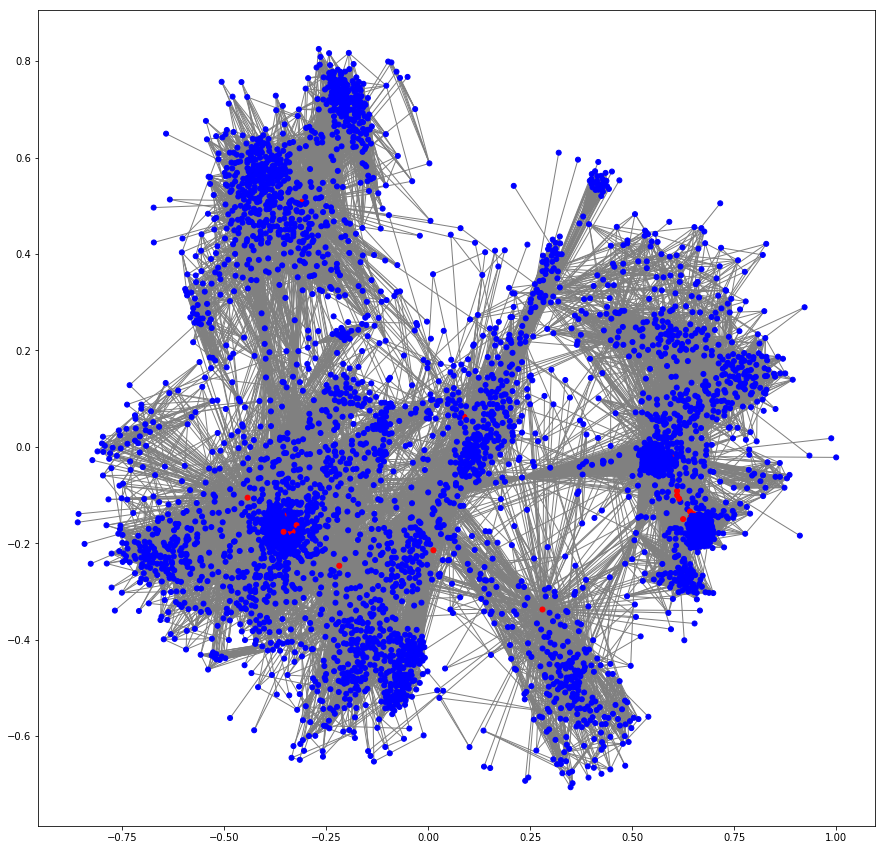

In [46]:
color_map = []
for node in graph.nodes():
    if (node in top20_influencers):
        # Set color of the important node
        color_map.append('r')
    else:
        color_map.append('b')

plt.figure(figsize=(15, 15))

#set the argument 'with labels' to False so you have unlabeled graph
nx.draw_networkx(
    graph,
    pos,
    node_size=25,
    node_color=color_map,
    with_labels=False,
    edge_color='gray')

## Information about how connected our users are :

In [47]:
degrees_values = pd.DataFrame([deg[1] for deg in degrees])
print(degrees_values.describe())

                 0
count  4039.000000
mean     43.691013
std      52.420605
min       1.000000
25%      11.000000
50%      25.000000
75%      57.000000
max    1045.000000


**It seems that the highest number of contacts a user have is 1045, but the mean is approximately of 43 contacts and only 25% of the users have more than 57contacts.**

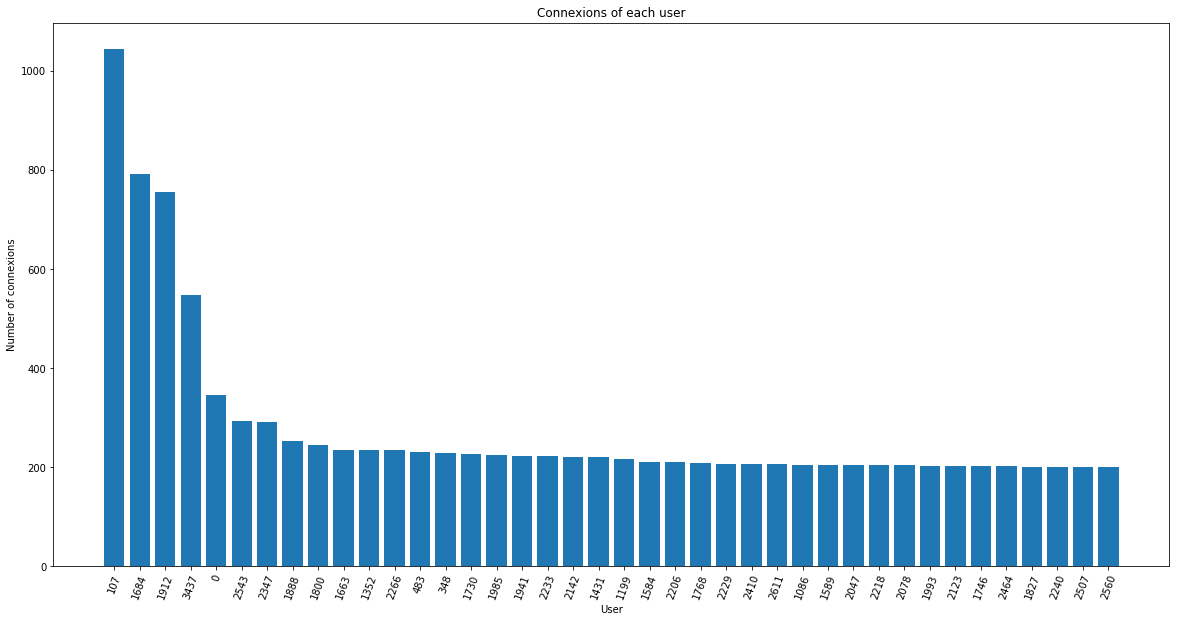

In [49]:
#Our array of ordered degrees, taking only the 40 highest degrees
degrees_max = degrees[:40]
plt.figure(figsize=(20, 10))
plt.bar(range(len(degrees_max)), [val[1] for val in degrees_max], align='center')
plt.xticks(range(len(degrees_max)), [val[0] for val in degrees_max])
plt.title('Connexions of each user')
plt.ylabel('Number of connexions')
plt.xlabel('User')
plt.xticks(rotation=70)
plt.show()

## The influencers in their communities

### Communities in the graph:

install community using : pip install python-louvain

In [50]:
import community

In [51]:
parts = community.best_partition(graph)
values = [parts.get(node) for node in graph.nodes()]

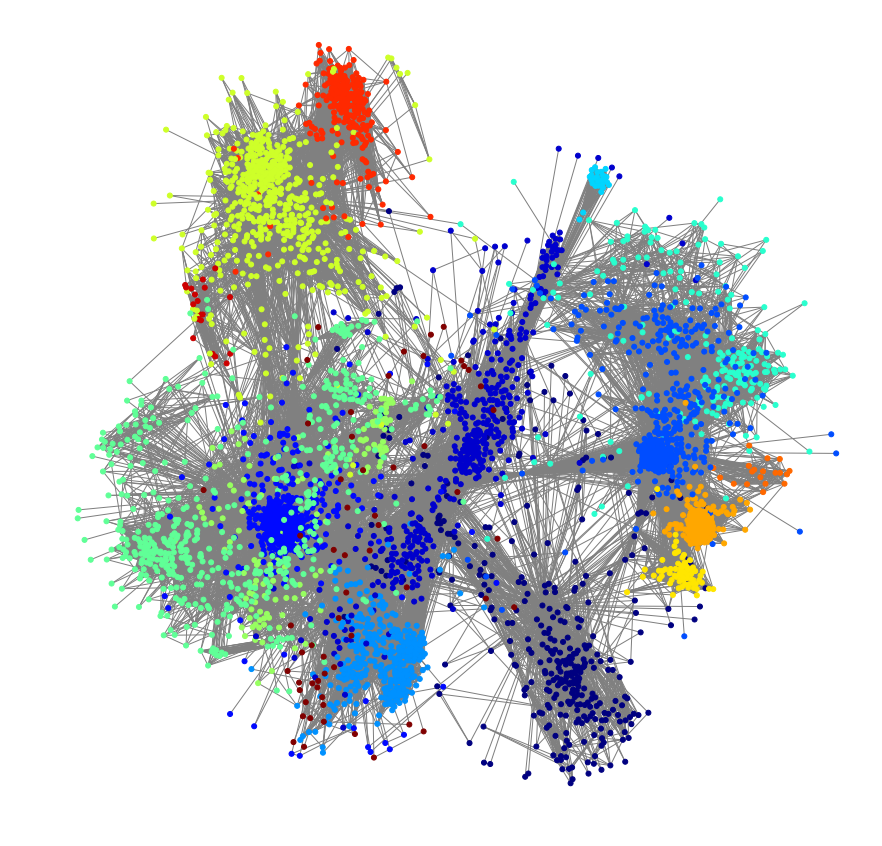

In [52]:
plt.figure(figsize=(15, 15))
plt.axis("off")
nx.draw_networkx(
    graph,
    pos=pos,
    cmap=plt.get_cmap("jet"),
    node_color=values,
    node_size=25,
    with_labels=False,
    edge_color='gray')

The criteria for finding good communities is similar to that for finding good clusters. We want to maximize intra-community edges while minimizing inter-community edges. Formally, the algorithm tries to maximize the modularity of network, or the fraction of edges that fall within the community minus the expected fraction of edges if the edges were distributed by random. Good communities should have a high number of intra-community edges, so by maximizing the modularity, we detect dense communities that have a high fraction of intra-community edges.

source : https://blog.dominodatalab.com/social-network-analysis-with-networkx/

## Within each community :

### Seperate the communities:

In [67]:
node_partition_df = pd.DataFrame(
    index=list(parts.keys()),
    data=list(parts.items()),
    columns=['node', 'partition'])

partition_nodes = node_partition_df.groupby('partition')['node'].apply(list)
partition_nodes_df = pd.DataFrame(partition_nodes)
partition_nodes_df.columns = ['nodes']
partition_nodes_df.head(3)

,nodes
partition,
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,"[34, 173, 198, 348, 349, 350, 351, 352, 353, 3..."
2,"[107, 897, 899, 904, 906, 907, 911, 916, 918, ..."


In [68]:
degrees_df = pd.DataFrame(degrees)
degrees_df.columns = ['node', 'degree']
degrees_df.head(3)

,node,degree
0,107,1045
1,1684,792
2,1912,755


### Find the best influencer(s) within each community

**We merge the 2 data frames to get the best influencer in each community/cluster.**

In [69]:
node_deg_part = node_partition_df.merge(degrees_df, left_on='node', right_on='node')
node_deg_part.head(3)

,node,partition,degree
0,0,0,347
1,1,0,17
2,2,0,10


In [70]:
node_deg_part.partition.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [71]:
maxes = node_deg_part.groupby('partition')['degree'].idxmax()
best_influencers = node_deg_part.loc[maxes].reset_index().drop(['index'], axis=1)

,node,partition,degree
0,0,0,347
1,483,1,231
2,107,2,1045
3,1912,3,755
4,917,4,130
5,583,5,25
6,686,6,170
7,3437,7,547
8,1687,8,43
9,1684,9,792


**Above you can find the best influencer in each community, and hence the Customer Relations team can only target them instead everyone. By sending the influencers a message to convince them, the team maximizes the chances of the message to go viral, and minimizes the cost of convincing everyone.**